<img align="right" width="200" height="200" src="https://static.wikia.nocookie.net/lego/images/2/23/PPG_logo.png"> 

# <span style="color:#EF7C8E">Introduction 2 - Heuristic Modeling Assignment - Machine Learning </span>
 


## <span style="color:#55BB99"> By: Wejdan Al-Ahmadi</span>
<hr style="border:2px solid gray"> </hr>

In [45]:
#here is an example of how to build and populate a hurestic model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import datetime
from matplotlib.pyplot import figure
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score

# Load Data
df = pd.read_csv('./data/seattle_weather_1948-2017.csv')

### <span style="color:#EF7C8E">1. Data Cleaning</span>

In [2]:
def RAIN_INSERTION(cols):
    """
    Insert False where NaN values are present
    """
    RAIN=cols[0]
    if pd.isnull(RAIN):
        return False
    else:
        return RAIN
    
def PRCP_INSERTION(col):
    """
    Insert the Mean of PRCP where NaN values are present
    """
    PRCP=col[0]
    if pd.isnull(PRCP):
        return df['PRCP'].mean()
    else:
        return PRCP

In [3]:
# Apply the functions
df['RAIN']=df[['RAIN']].apply(RAIN_INSERTION,axis=1)
df['PRCP']=df[['PRCP']].apply(PRCP_INSERTION,axis=1)

In [4]:
# First quartile (Q1)
Q1 = np.percentile(df['TMAX'], 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(df['TMAX'], 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1

# lower bound outliers --> Q1 - 1.5(IQR)
# higher bound outliers --> Q3 + 1.5 (IQR)


print(Q3+ 1.5*(IQR))

97.5


In [5]:
df.head(5)

DATE  PRCP  TMAX  TMIN  RAIN
0  1948-01-01  0.47    51    42  True
1  1948-01-02  0.59    45    36  True
2  1948-01-03  0.42    45    35  True
3  1948-01-04  0.31    45    34  True
4  1948-01-05  0.17    45    32  True

In [6]:
#Dropping the outliers from TMIN column
df=df.drop(df[df['TMIN']<17 ].index)
#Dropping the outliers from TMAX columns i.e. the value more than 100
df=df.drop(df[(df['TMAX']>97.5) | (df['TMAX']< 21.5)].index)
#Dropping the outliers from PRCP columns i.e. the value more than 0.275
df=df.drop(df[(df['PRCP']>0.25) | (df['PRCP']< -0.15) ].index)

### <span style="color:#EF7C8E">2. Coding Heuristic for Rain Predictions by hand and evaluating</span>

Conditions: 
- If it rained yesterday or the day before then it will rain today

In [7]:
# Reset index and drop index column
df = df.reset_index().drop("index", axis=1)

In [8]:
rain_pred_df = df.copy()

<AxesSubplot:xlabel='TMIN', ylabel='Count'>

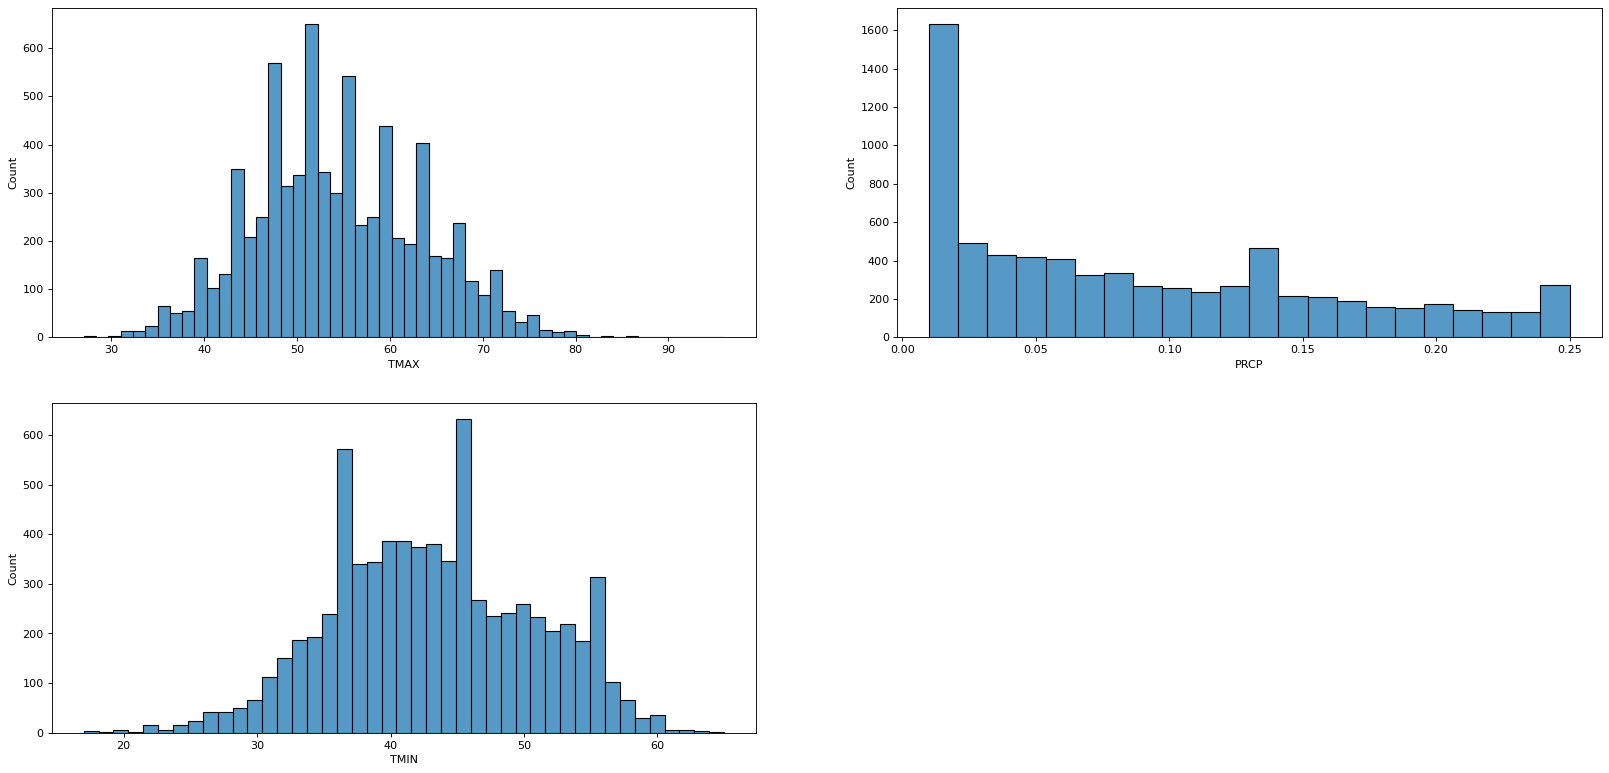

In [9]:
# Plotting the TMAX, TMIN and PRCP when it rains to get the numbers to use in my conditions
figure(figsize=(25, 12), dpi=80)
plt.subplot(2,2,1)
sns.histplot(x="TMAX", data=df[df["RAIN"]==True])
plt.subplot(2,2,2)
sns.histplot(x="PRCP", data=df[df["RAIN"]==True])
plt.subplot(2,2,3)
sns.histplot(x="TMIN", data=df[df["RAIN"]==True])


In [10]:
# Create function to perform our heuristic

# rain --> rain
# rain, 'unknown' --> rain 

# x --> Tomorrow
# x-1 --> Today
# x-2 --> Yesterday

def heuristic_rain(df):
    
    """
    Simple heuristic:
    
    If it rained yesterday or the day before yesterday
    
    then predict rain else predict no rain
    
    Frist two rows are predicted false be default
    """
    
    preds = []
    for x in range(len(df)):
        if x <2:
            preds.append(False)
        else:
            if (df.iloc[x-1]["RAIN"] == True):
                if(df.iloc[x]["TMAX"]<=65) & (df.iloc[x]["PRCP"] >=0.01)&(df.iloc[x]["TMIN"]<=45):
                    preds.append(True)
                else: 
                    preds.append(False)  
            elif (df.iloc[x-2]["RAIN"] == True):
                if (df.iloc[x]["TMAX"]<=65) & (df.iloc[x]["PRCP"] >=0.01)&(df.iloc[x]["TMIN"]<=45):
                    preds.append(True)
                else:
                    preds.append(False)
            elif (df.iloc[x-3]["RAIN"] == True):
                if (df.iloc[x]["TMAX"]<=65) & (df.iloc[x]["PRCP"] >=0.01)&(df.iloc[x]["TMIN"]<=45):
                    preds.append(True)
                else:
                    preds.append(False)

            else: 
                preds.append(False)
    return preds

# this ones accuracy is: 0.7650390535787694

### <span style="color:#EF7C8E">3. Calculating the confusion matrix for Rain Predictions</span>

In [11]:
# Determine Accuracy

# Create function to to find values

def calc_confuse_rain(df):
    
    "Calculate all possible results of a confusion matrix"

    # Hold all possible values and set to zero
    FP = np.zeros(len(df))
    TP = np.zeros(len(df))
    FN = np.zeros(len(df))
    TN = np.zeros(len(df))
    
    for x in range(len(df)):
        
        # True Positive
        if (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == True):
            TP[x] = 1
        # True Negative
        elif (df["RAIN"].iloc[x] == False) & (df["preds"].iloc[x] == False):
            TN[x] = 1
        # False Negative
        elif (df["RAIN"].iloc[x] == True) & (df["preds"].iloc[x] == False):
            FN[x] = 1
        # False Positive
        else:
            FP[x] = 1
    
    return FP, TP, FN, TN

In [12]:
# Apply Heuristic
rain_pred_df["preds"] = heuristic_rain(rain_pred_df)


# Extract results and create columns for each
w,x,y,z = calc_confuse_rain(rain_pred_df)

rain_pred_df["FP"] = w
rain_pred_df["TP"] = x
rain_pred_df["FN"] = y
rain_pred_df["TN"] = z

# Calculate Accuracy
(sum(rain_pred_df["TP"]) + sum(rain_pred_df["TN"])) / len(rain_pred_df)


0.8408623761019504

In [13]:
# Baseline Model Prediction
# What would be our accuracy if we predicted the majority class

df["RAIN"].value_counts(normalize=True)

False    0.665464
True     0.334536
Name: RAIN, dtype: float64

### <span style="color:#EF7C8E">3. Heuristic Rain Prediction Conclusion:</span>
After taking a deeper look into the dataset, I noticed when the TMAX is higher but not too high it tends to rain, I also noticed that when the PRCP is equal to 0 its almost always not raining, Also when looking into weather forecasting I noticed they tend to look at the day before and the day of. I plotted these variables against the dataset only when it rains since that is my desired target to predict and I reached to a conclusion that it tends to rain more on days that have a TMAX 65 or less and a PRCP above 0.01 and a TMIN 45 or higher. I used this knowledge in writing my code. 
I iterated through the code and tried many different conditions and got a range of accurracies from: {63,64,66,67,69,73,74,76, 84}. 
My Highest accuracy was 84 and I reached it with the following Psuedo code that I implemented into the function: 


Heuristic Psuedo Code: 

 1) If it rained yesterday
 
     1.1) If todays TMAX is 65 degrees or less, AND If todays PRCP is above 0.01, AND If the TMIN is 45 or higher
     
         1.1.1) Then it rained
         
         
    1.2) Else --> It will not rain


 2) Else If it rained two days before
 
     2.1) If todays TMAX is 65 degrees or less, AND If todays PRCP is above 0.01, AND If the TMIN is 45 or higher
     
         2.1.1) Then it rained
  
      2.2) Else --> It will not rain
      
      
 3) Else If it rained three days before
 
     3.1) If todays TMAX is 65 degrees or less, AND If todays PRCP is above 0.01, AND If the TMIN is 45 or higher
     
          3.1.1) Then it rained
            
      3.2) Else --> It will not rain


 4) Else --> It will not rain

### <span style="color:#EF7C8E">4. Heuristic PRCP Prediction:</span>

In [14]:
prcp_pred_df = df.copy()

In [15]:
prcp_pred_df.PRCP.describe()

count    21893.000000
mean         0.030588
std          0.059266
min          0.000000
25%          0.000000
50%          0.000000
75%          0.030000
max          0.250000
Name: PRCP, dtype: float64

#### <span style="color:#55BB99"> 1) MSE Function:</span>

In [16]:
# Create a Mean Squared Error Function
def mse(y_true, y_pred):
    squared_delta=(y_true-y_pred)**2
    mse=sum(squared_delta)/len(y_true)
    return mse

#### <span style="color:#55BB99"> 2) PRCP Prediction with mean:</span>

In [17]:
"""
This function predicts the PRCP using the mean of the column 
"""
def heuristic_prcp_mean(df):
    preds = np.zeros(len(df))
    for x in range(len(df)):
        preds[x]=round(df.PRCP.mean(), 2)
    return preds

# Apply Heuristic and get the MSE
prcp_pred_df["PRCP_mean"] = heuristic_prcp_mean(prcp_pred_df)
mse(prcp_pred_df["PRCP"], prcp_pred_df["PRCP_mean"])

0.0035126583477375806

#### <span style="color:#55BB99"> 3) PRCP Prediction with mean and first std:</span>

In [22]:
"""
This function predicts the PRCP using a range between the mean and the first std of the column

"""
def heuristic_prcp_std1(df):
    preds = np.zeros(len(df))
    for x in range(len(df)):
        preds[x]=round(random.uniform(df.PRCP.mean(),df.PRCP.std()), 2)
    return preds

# Apply Heuristic and get the MSE
prcp_pred_df["PRCP_PREDS_STD1"] = heuristic_prcp_std1(prcp_pred_df)
mse(prcp_pred_df["PRCP"], prcp_pred_df["PRCP_PREDS_STD1"])

0.003807169331746046

#### <span style="color:#55BB99"> 4) PRCP Prediction with mean and the second std:</span>

In [20]:
"""
This function predicts the PRCP using a range between the mean and the second std of the column

"""
def heuristic_prcp_std2(df):
    preds = np.zeros(len(df))
    second_std=df.PRCP.mean() + 2 * df.PRCP.std()
    for x in range(len(df)):
        preds[x]=round(random.uniform(df.PRCP.mean(),second_std), 2)
    return preds

# Apply Heuristic and get the MSE
prcp_pred_df["PRCP_PREDS_STD2"] = heuristic_prcp_std2(prcp_pred_df)
mse(prcp_pred_df["PRCP"], prcp_pred_df["PRCP_PREDS_STD2"])

0.008276979575915326

#### <span style="color:#55BB99"> 5) PRCP Prediction with mean and std using Temp(TMAX and TMIN) range:</span>

In [23]:
"""
This function predicts the PRCP using a range between the mean and the std of the column, rows that meet the temp conditions
"""
def heuristic_prcp_temp(df):
    preds = np.zeros(len(df))
    for x in range(len(df)):
        if(42>=df.iloc[x]["TMAX"]<=50)&(30>=df.iloc[x]["TMIN"]<=45):       # if row is between TMAX(42,50) and TMIN(30,45)
            preds[x]=round(random.uniform(df.PRCP.mean(),df.PRCP.std()), 2)# predict PRCP based on overall mean and std
        else:                                                              # otherwise its equal to zero
            preds[x]=0
    return preds

# Apply Heuristic and get the MSE
prcp_pred_df["PRCP_PREDS_TEMP"] = heuristic_prcp_temp(prcp_pred_df)
mse(prcp_pred_df["PRCP"], prcp_pred_df["PRCP_PREDS_TEMP"])

0.00444233997620107

<AxesSubplot:xlabel='TMAX', ylabel='PRCP'>

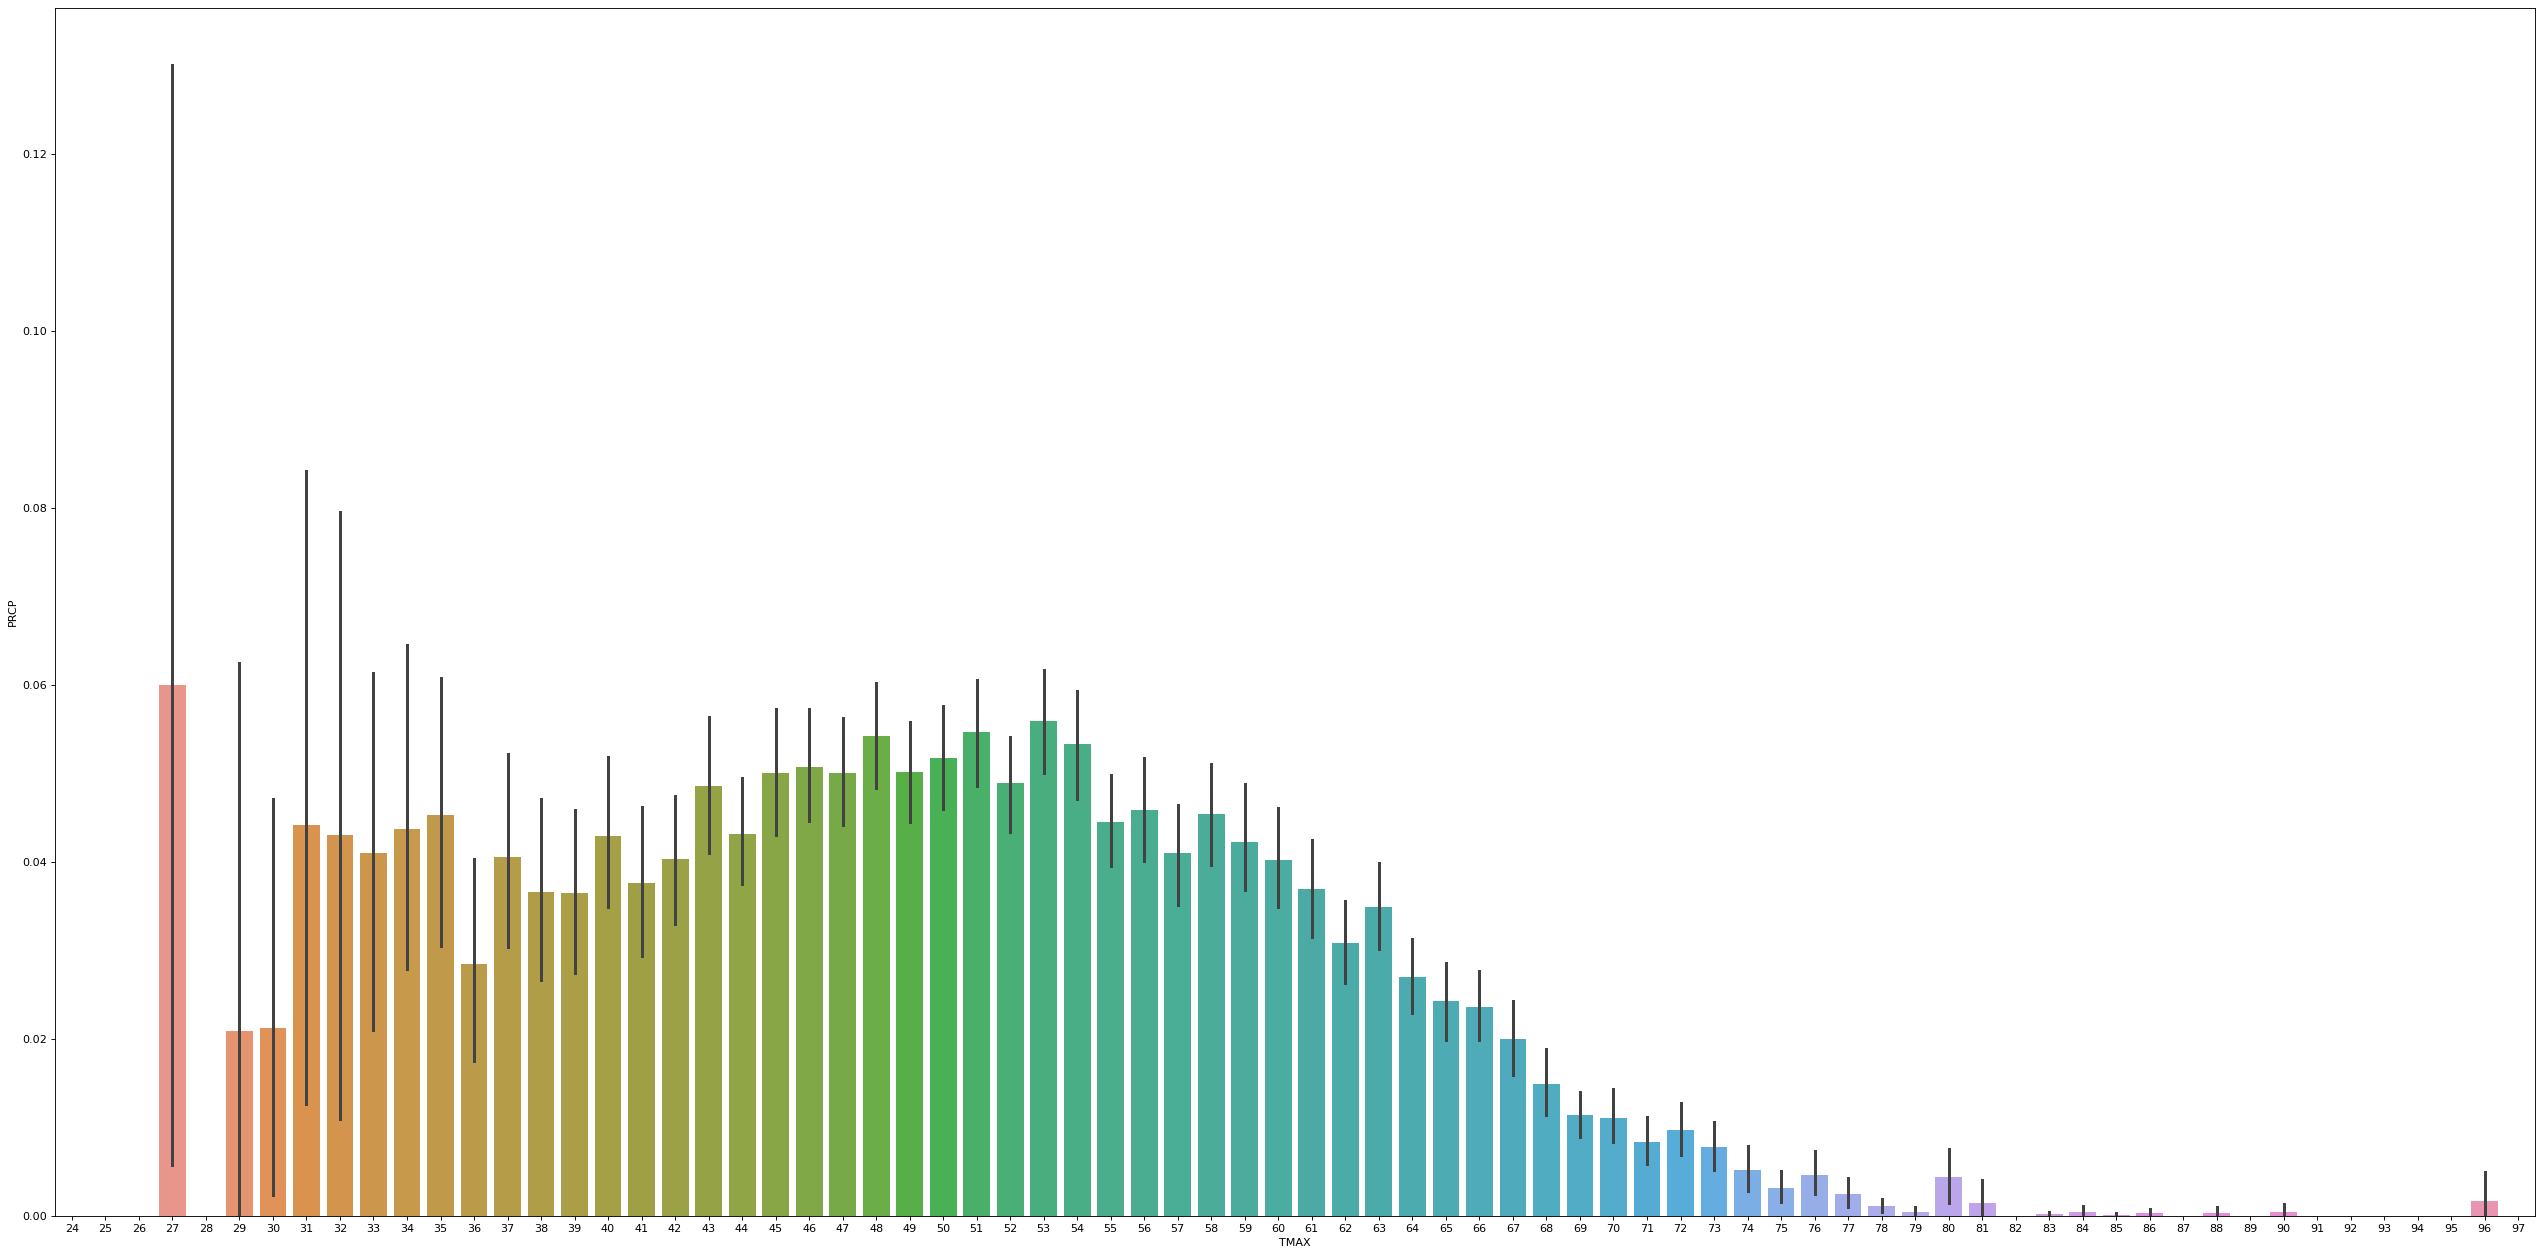

In [18]:
# Plotting the TMAX against the PRCP to understand the range of the values
figure(figsize=(40, 20), dpi=80)
sns.barplot(x=df.TMAX, y=df.PRCP)

<AxesSubplot:xlabel='TMIN', ylabel='PRCP'>

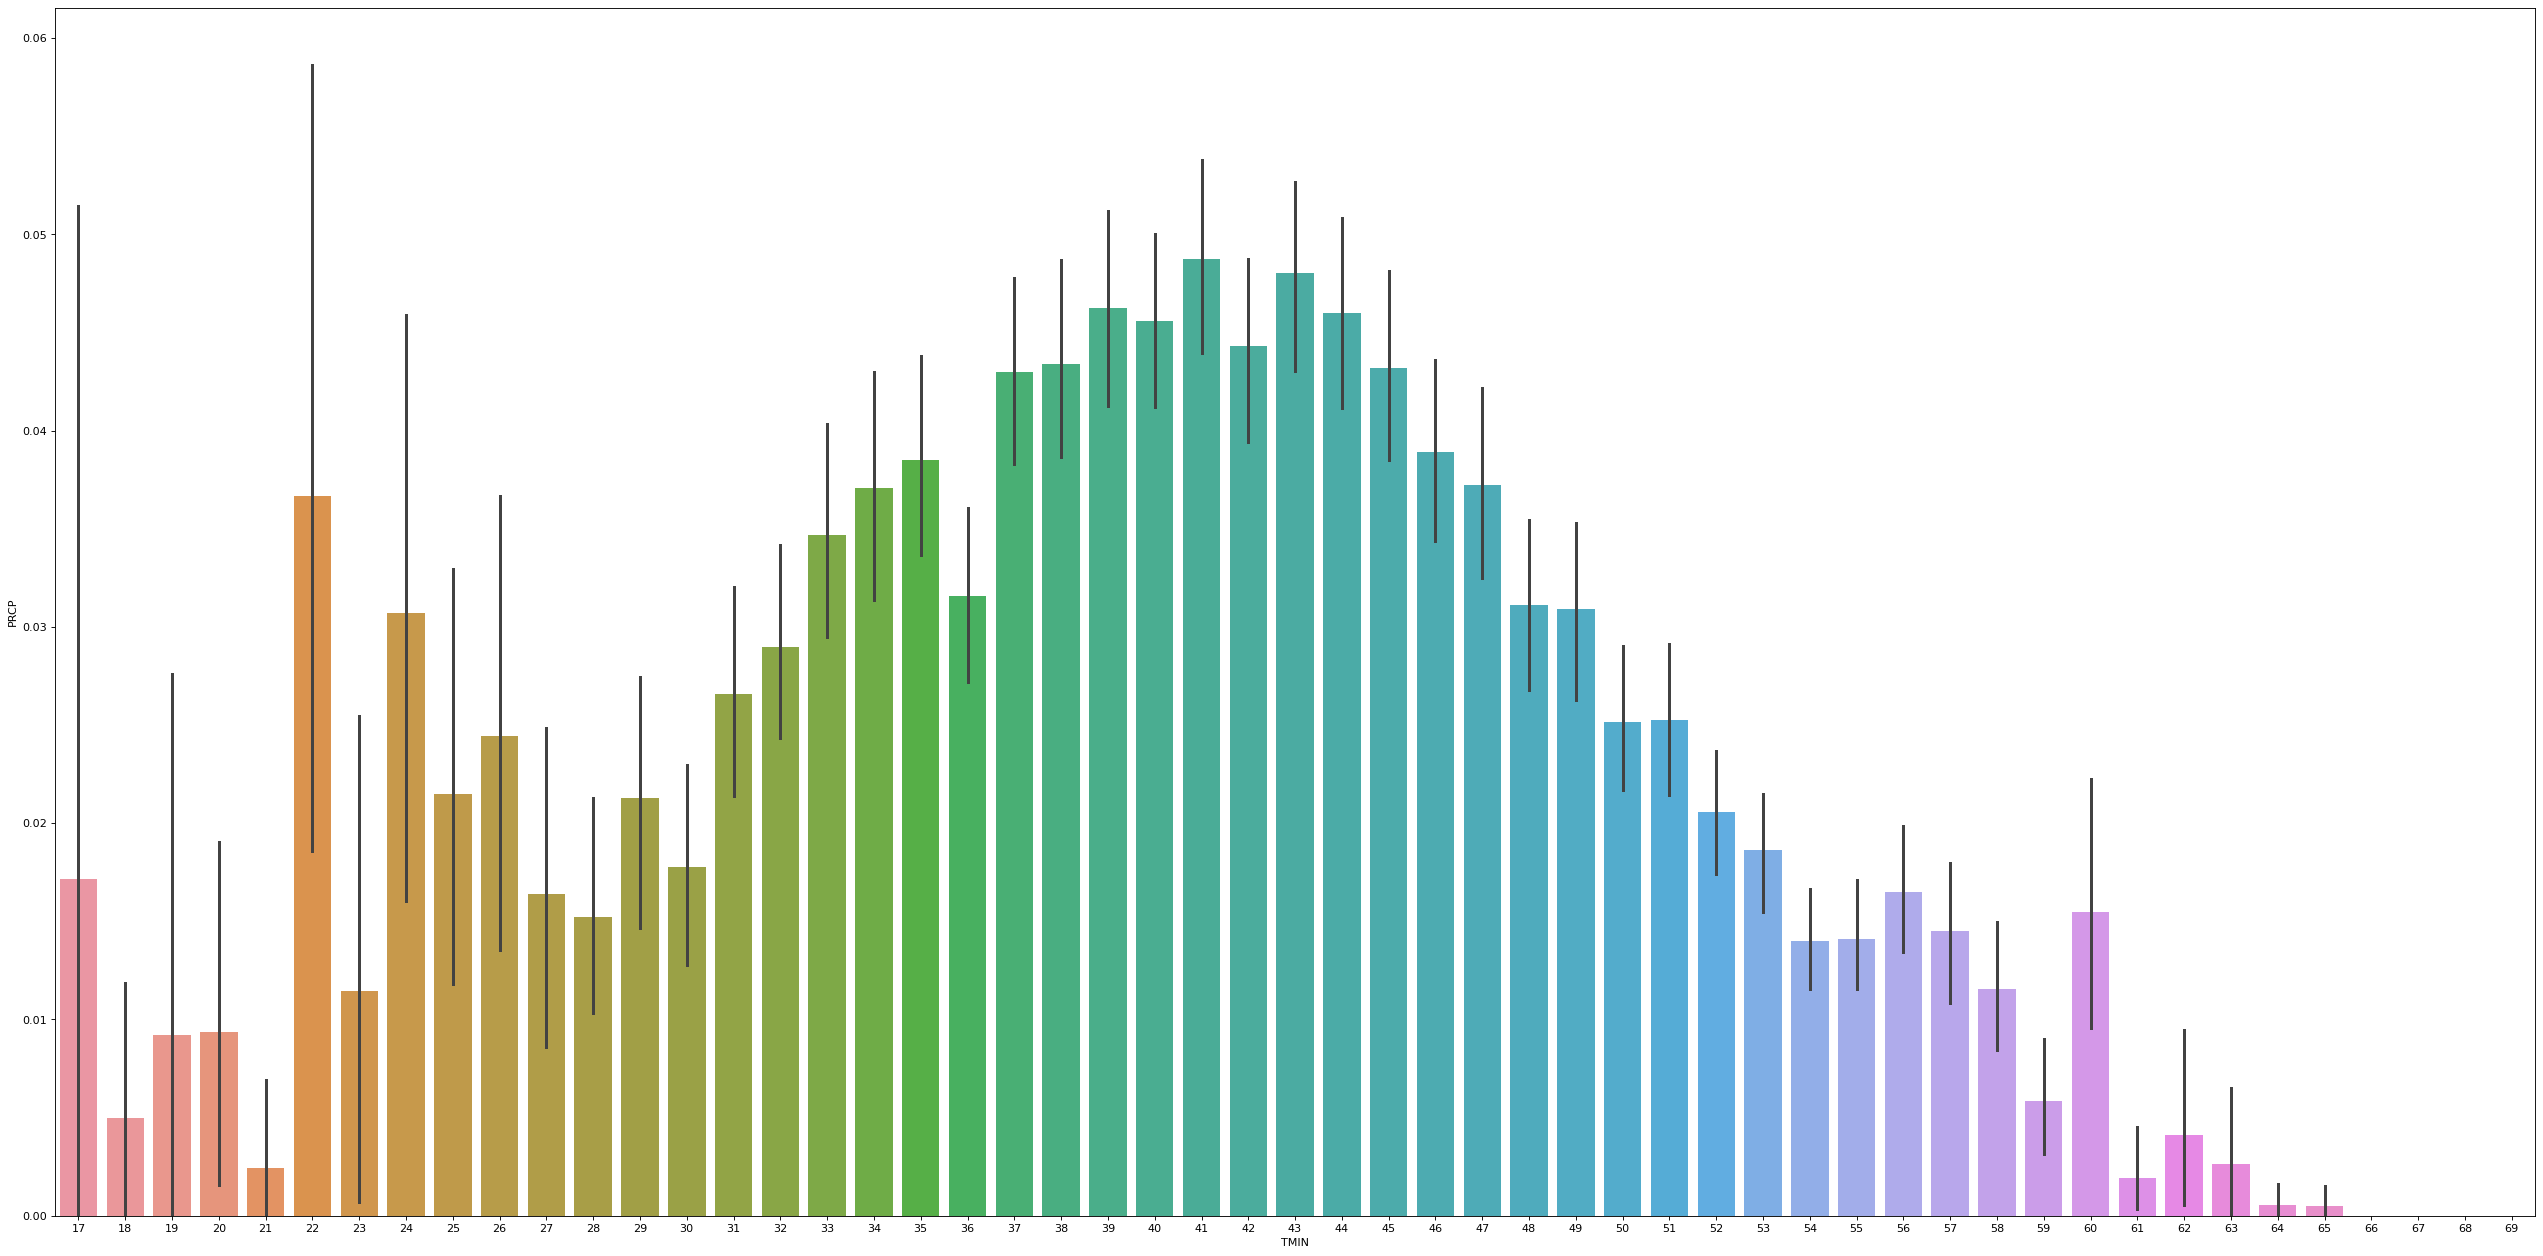

In [19]:
# Plotting the TMIN against the PRCP to understand the range of the values
figure(figsize=(40, 20), dpi=80)
sns.barplot(x=df.TMIN, y=df.PRCP)

#### <span style="color:#55BB99"> 6) PRCP Prediction with subset mean and subset std using Temp(TMAX and TMIN) range:</span>

In [41]:
"""
This function predicts the PRCP using a subset taken based on the barplots above, 
First I took a subset of the dataset where the TMAX's range is between 31 and 54 degrees, 
and the TMIN's range is between 34 and 43 degrees, I then took the mean and std of the PRCP that lies in that subset
and used that to predict the PRCP. 


"""
def heuristic_prcp_temp2(df):
    preds = np.zeros(len(df))
    
    # get a subset of the data to get the mean and the std of that specific subset that meets these conditions
    subset=df[(df["TMAX"]<=54)&(df["TMAX"]>=31)&(df["TMIN"]<=43)&(df["TMIN"]>=34)]
    # get the mean of the PRCP
    subset_mean=subset.PRCP.mean()
    # get the std of the PRCP
    subset_std=subset.PRCP.std()
    
    for x in range(len(df)):
        if(31>=df.iloc[x]["TMAX"]<=54)&(34>=df.iloc[x]["TMIN"]<=43):  # this condition ensures that the prcp is predicted for a certain range
            preds[x]=round(random.uniform(subset_mean,subset_std), 2) # randomize between the mean and std
        else:                                                         # otherwise its equal to 0
            preds[x]=0
    return preds

# Apply Heuristic and get the MSE
prcp_pred_df["PRCP_PREDS_TEMP2"] = heuristic_prcp_temp2(prcp_pred_df)
mse(prcp_pred_df["PRCP"], prcp_pred_df["PRCP_PREDS_TEMP2"])

0.004449255428628796

### <span style="color:#EF7C8E">3. Heuristic PRCP Prediction Conclusion:</span>

I predicted the PRCP using 4 different methods along with the mean method suggested in the Learn, I will compare the results: 

1. PRCP Prediction with mean **result: 0.0035126583477375806**
1. PRCP Prediction with mean and first std **result: 0.003807169331746046**
1. PRCP Prediction with mean and the second std **result:0.008276979575915326**
1. PRCP Prediction with mean and std using Temp(TMAX and TMIN) range **result: 0.00444233997620107**
1. PRCP Prediction with subset mean and subset std using Temp(TMAX and TMIN) range MSE **result: 0.004449255428628796**

*Comparing the results:*

| Method      | MSE Result |
| :----------- | :----------- |
| Mean      | 0.0035       |
| Mean and 1st std   | 0.0038        |
| Mean and 2nd std   | 0.0082        |
| Mean and 1st std Temp   | 0.0044        |
| Mean and 1st std of Temp Range   | 0.0044        |


**In conclusion**, none of the methods I used are better than replacing with the mean, since it is the closest to zero. 

### <span style="color:#EF7C8E">4. Precision, Recall and Accuracy of Rain Prediction:</span>

In [42]:
# Create A Function to Calculate Precision
def precision(TP, FP):
    bottom=sum(TP+FP)
    top = sum(TP)
    return top/bottom 

precision(rain_pred_df["TP"], rain_pred_df["FP"])

1.0

In [47]:
precision_score(rain_pred_df["RAIN"], rain_pred_df["preds"])

1.0

In [43]:
# Create A Function to Calculate Recall
def recall(TP, FN):
    return(sum(TP)/sum(TP+FN))

recall(rain_pred_df["TP"], rain_pred_df["FN"])

0.5243036592026216

In [48]:
recall_score(rain_pred_df["RAIN"], rain_pred_df["preds"])

0.5243036592026216

In [44]:
# Create a Function to Calculate Accuracy
def accuracy(TP, FP, TN, FN):
    return(sum(TP+TN)/sum(TP+TN+FP+FN))

accuracy(rain_pred_df["TP"], rain_pred_df["FP"], rain_pred_df["TN"], rain_pred_df["FN"])

0.8408623761019504

In [49]:
accuracy_score(rain_pred_df["RAIN"], rain_pred_df["preds"])

0.8408623761019504